# IMPORT

In [189]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import inflection

from yellowbrick.contrib.wrapper import wrap
from yellowbrick.classifier import ClassPredictionError, ConfusionMatrix, ClassificationReport, ROCAUC
from scikitplot.metrics import plot_ks_statistic

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from scipy import stats

from sklearn.impute import SimpleImputer

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, RandomizedSearchCV
from scipy.stats import shapiro, normaltest, jarque_bera
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from boruta import BorutaPy

# HELPER FUNCTIONS

In [2]:
def corr_two(a, b):
    # name of the atributes
    a_name = a.columns[0]
    b_name = b.columns[0]
    
    # change to an array
    a = a.values.reshape(-1)
    b = b.values.reshape(-1)
    
    # calculate de correlation
    c = np.corrcoef(a, b)
    
    # create a dataframe
    df = pd.DataFrame(c, columns = [a_name, b_name], index = [a_name, b_name])
    
    # return a heatmap
    return sns.heatmap(df, annot = True).set_title('{} x {}'.format(a_name, b_name))

# CHARGING DATA 

In [3]:
df_raw = pd.read_csv('dataset/churn.csv')

# DATA DESCRIPTION

In this section we'll describe the data renaming some columns, see his dimensions, the type of the data and check if there any NaN values.

In [4]:
df1 = df_raw.copy()

### Rename the columns
 - First we'll change the name of the columns to "camelcase" to "sneakcase", that will improve our data manipulation.

In [5]:
sneakcase = lambda x: inflection.underscore(x)
columns_map = ['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited']

list_columns = list(map(sneakcase, columns_map))
df1.columns = list_columns

### Data Dimension

In [6]:
print('Number of rows {}'.format(df1.shape[0]))
print('Number of columns {}'.format(df1.shape[1]))

Number of rows 10000
Number of columns 14


### Data Types and Info

In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            10000 non-null  int64  
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


 - We see that most of the data is an int values or float, there is a little numbers of variables that is categorical.
 - Mostly of data are not null, we can confirm it in the next sector.

### Check NaN values

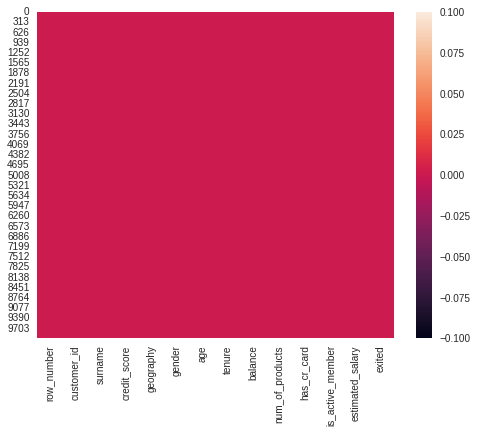

In [8]:
plt.figure(figsize=(8,6));
sns.heatmap(df1.isnull());

We see that it doesn't have any Null or NaN values, so we don't need to make any data treatment.

### Descriptive Statistics

In [9]:
df1_num = df1.select_dtypes(include = ['int64', 'float64'])
df1_cat = df1.select_dtypes(exclude = ['int64', 'float64'])

# Descritive numerical statistics 
df_min = pd.DataFrame(df1_num.min())
df_max = pd.DataFrame(df1_num.max())
df_range = pd.DataFrame(df_max - df_min)
df_mean = pd.DataFrame(df1_num.mean())
df_std = pd.DataFrame(df1_num.std())
df_skew = pd.DataFrame(df1_num.skew())
df_kurtosis = pd.DataFrame(df1_num.kurtosis())

df_description = pd.concat([df_min, df_max, df_range, df_mean, df_std, df_skew, df_kurtosis], axis = 1).round(2)
df_description.columns = ['min', 'max', 'range', 'mean', 'std', 'skew', 'kurtosis']
df_description

,min,max,range,mean,std,skew,kurtosis
row_number,1.00,10000.00,9999.00,5000.50,2886.90,0.00,-1.20
customer_id,15565701.00,15815690.00,249989.00,15690940.57,71936.19,0.00,-1.20
credit_score,350.00,850.00,500.00,650.53,96.65,-0.07,-0.43
age,18.00,92.00,74.00,38.92,10.49,1.01,1.40
tenure,0.00,10.00,10.00,5.01,2.89,0.01,-1.17
balance,0.00,250898.09,250898.09,76485.89,62397.41,-0.14,-1.49
num_of_products,1.00,4.00,3.00,1.53,0.58,0.75,0.58
has_cr_card,0.00,1.00,1.00,0.71,0.46,-0.90,-1.19
is_active_member,0.00,1.00,1.00,0.52,0.50,-0.06,-2.00
estimated_salary,11.58,199992.48,199980.90,100090.24,57510.49,0.00,-1.18


 - Mostly of the data has a negative kurtosis, indicate the data has a spread distribution.
 - The age data has a skew positive, indicate mostly of users are young.
 - The balance value follow a normal curve as the estimated salary.
 - Probably, most of users has a credit card.

### Outliers 

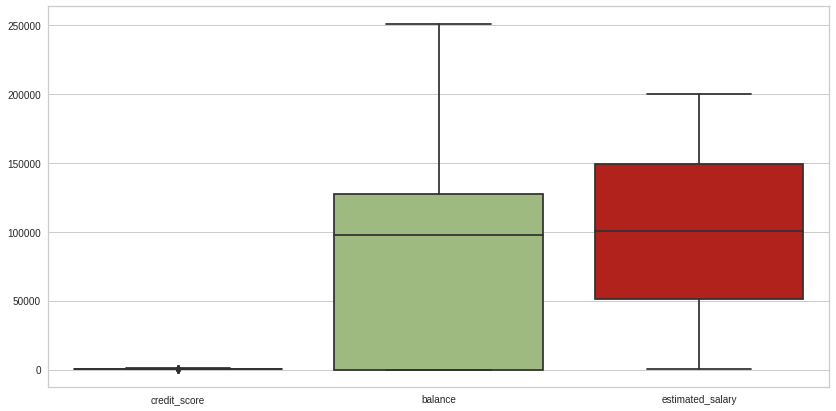

In [10]:
df_aux_num = df1[['credit_score', 'balance', 'estimated_salary']]
plt.figure(figsize = (14,7));
sns.boxplot(data = df_aux_num);

We see that it doesn't have a presence of outliers of the some numeric values.

### Duplicated Values 

In [11]:
df1.duplicated(subset = ['customer_id']).sum()

0

It doesn't have any duplicated value, so we don't need to make any treatment in our data.

# FEATURE ENGENEERING

## Mental Map

Next we'll built a mental map to better understand our business problem and make some business hypoteses to further evaluation.

This mental map can be made with a reunion with other areas of the company or it can be built with your personal research of the business.

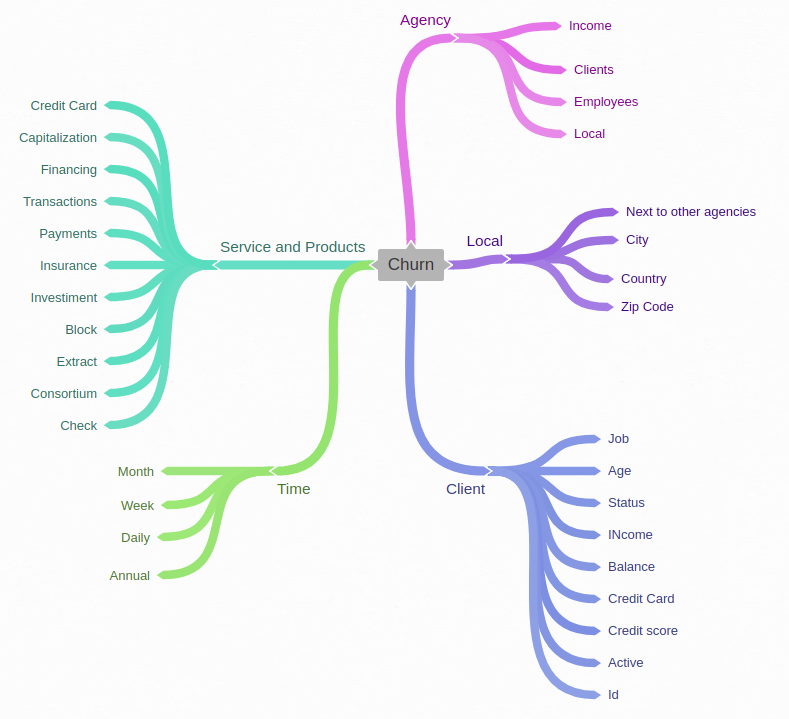

## Hipothesis
After we analise the data, we'll make some assumptions about the business in order to give some actionable insights to other teams.

### Agency
- The agency that has less income has more churn rate?
- Agency that has less employees, has more churn rate?

### Local
- Agencies that are next to other bank agencies has more churn rate?
- Agencies that are located in the center has more churn rate than others?

### Client
- Clients who left are young?
- Clients who left has a low credit card score?
- Clients who left are not active?
- Clients who left buy less products?
- Clients who left has a low tenure?
- Clients who left has no jobs?
- Clients who left has low income?
- Clients who left has low balance?
- Clients who left has no credit card?
- Clients who left has no low amount?

### Time
- The churn rate increase the end of the year?
- The churn rate increase in the middle of the week?

### Service and Products
- The capitalization sector has more churn rate than other areas?
- People who left has no investments in the bank?
- People who left don't use our products?
- People who left don't use our service often?

## Filtering Hipothesis
After we made the hipothesys, we'll analyse and match what hypothesis that we can solve base in our data, resulting in the hypothesis below:

__H1:__ Clients who left are young? <br>
__H2:__ Clients who left have less income?<br>
__H3:__ Clients who left has a low credit card score?<br>
__H4:__ Clients who left are not active?<br>
__H5:__ Clients who left buy less products?<br>
__H6:__ Clients who left has a low tenure?<br>
__H7:__ Clients who left has low income?<br>
__H8:__ Clients who left has low balance?<br>
__H9:__ Clients who left has low amount?<br>

## Feature Engeneering
This section we'll create some features that will help us understand better our data and create some attributes that we can use in our assumptions.

In [12]:
df2 = df1.copy()

In [13]:
df2 = df2.drop(['row_number', 'surname'], axis = 1)

df2.rename(mapper = {'geography': 'country'}, inplace = True)

# Salary x Balance
df2['salary/balance'] = df2.apply(lambda x: x['estimated_salary'] / x['balance'] if x['balance'] != 0 else 0, axis = 1)

# Salary x Tenure
df2['salary/tenure'] = df2.apply(lambda x: x['estimated_salary'] / x['tenure'] if x['tenure'] !=0 else 0, axis = 1)

# Balance x Tenure
df2['balance/tenure'] =df2.apply(lambda x: x['balance'] / x['tenure'] if x['tenure'] != 0 else 0, axis = 1)

# Credit Score x Tenure
df2['score/tenure'] = df2.apply(lambda x: x['credit_score'] / x['tenure'] if x['tenure'] != 0 else x['credit_score'], axis = 1)

# Amount of money
df2['amount'] = df2['balance'] + df2['estimated_salary']

# Amout x Products
df2['amout/products'] = df2['amount'] / df2['num_of_products']

In [14]:
df2['tenure'].min()

0

# EXPLORATORY ANALYSIS

In [15]:
df3 = df2.copy()

## Univariated Analysis
In this section we'll se how the data behave individually, it give us some idea about how they perform.

In [16]:
df3_num = df3.select_dtypes(include = ['int64', 'float64'])
df3_cat = df3.select_dtypes(exclude = ['int64', 'float64'])

In [17]:
df3_num.columns

Index(['customer_id', 'credit_score', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited', 'salary/balance', 'salary/tenure',
       'balance/tenure', 'score/tenure', 'amount', 'amout/products'],
      dtype='object')

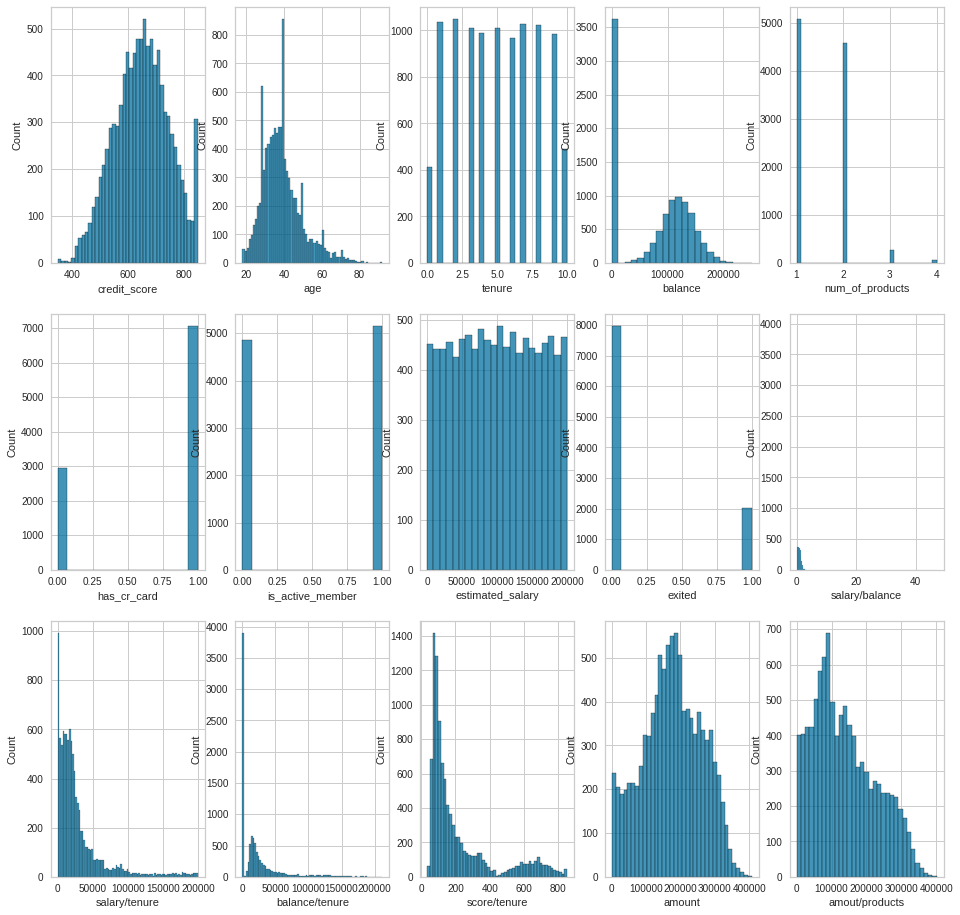

In [18]:
fig, axis = plt.subplots(3,5, figsize = (16,16))

sns.histplot(data = df3_num, x = 'credit_score', ax = axis[0,0]);
sns.histplot(data = df3_num, x = 'age', ax = axis[0,1]);
sns.histplot(data = df3_num, x = 'tenure', ax = axis[0,2]);
sns.histplot(data = df3_num, x = 'balance', ax = axis[0,3]);
sns.histplot(data = df3_num, x = 'num_of_products', ax = axis[0,4]);

sns.histplot(data = df3_num, x = 'has_cr_card', ax = axis[1,0]);
sns.histplot(data = df3_num, x = 'is_active_member', ax = axis[1,1]);
sns.histplot(data = df3_num, x = 'estimated_salary', ax = axis[1,2]);
sns.histplot(data = df3_num, x = 'exited', ax = axis[1,3]);
sns.histplot(data = df3_num, x = 'salary/balance', ax = axis[1,4]);

sns.histplot(data = df3_num, x = 'salary/tenure', ax = axis[2,0]);
sns.histplot(data = df3_num, x = 'balance/tenure', ax = axis[2,1]);
sns.histplot(data = df3_num, x = 'score/tenure', ax = axis[2,2]);
sns.histplot(data = df3_num, x = 'amount', ax = axis[2,3]);
sns.histplot(data = df3_num, x = 'amout/products', ax = axis[2,4]);

After that we'll analyse some attributes comparing the clients who left with who stay.

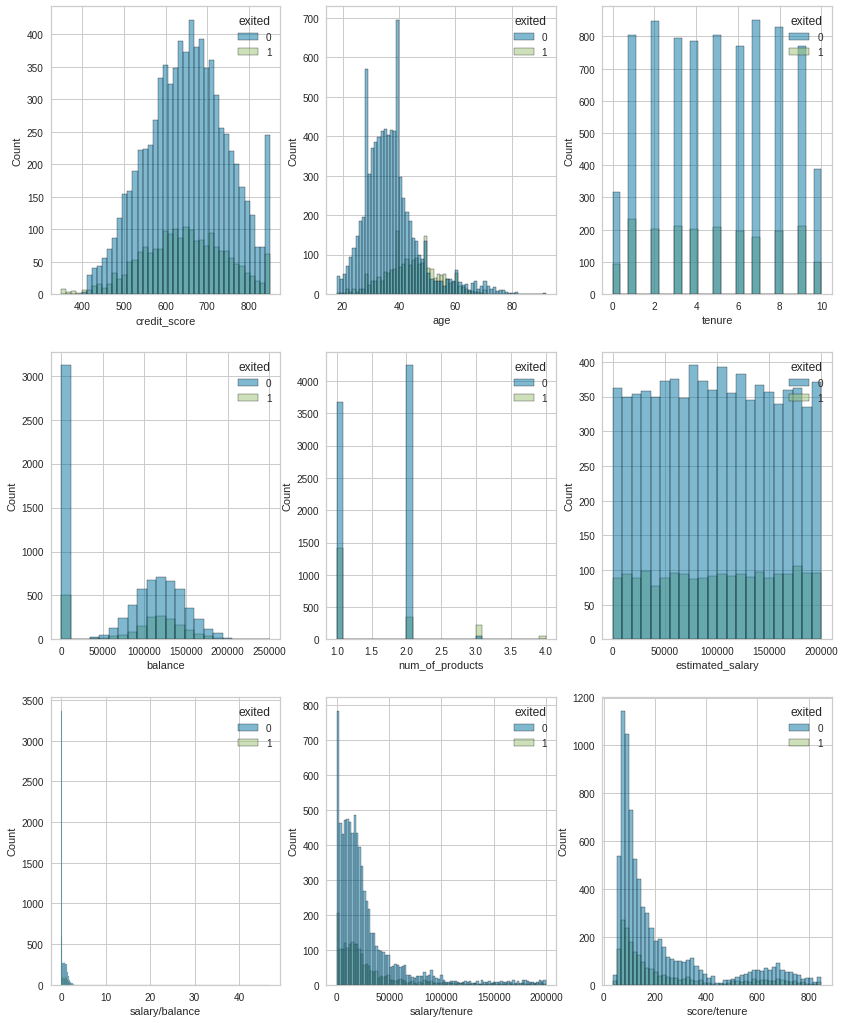

In [19]:
fig, axis = plt.subplots(3,3, figsize = (14,18))
sns.histplot(data = df3_num, x = 'credit_score', hue = 'exited', ax = axis[0,0]);
sns.histplot(data = df3_num, x = 'age', hue = 'exited', ax = axis[0,1]);
sns.histplot(data = df3_num, x = 'tenure', hue = 'exited', ax = axis[0,2]);
sns.histplot(data = df3_num, x = 'balance', hue = 'exited', ax = axis[1,0]);
sns.histplot(data = df3_num, x = 'num_of_products', hue = 'exited', ax = axis[1,1]);
sns.histplot(data = df3_num, x = 'estimated_salary', hue = 'exited', ax = axis[1,2]);
sns.histplot(data = df3_num, x = 'salary/balance', hue = 'exited', ax = axis[2,0]);
sns.histplot(data = df3_num, x = 'salary/tenure', hue = 'exited', ax = axis[2,1]);
sns.histplot(data = df3_num, x = 'score/tenure', hue = 'exited', ax = axis[2,2]);

In this data we can make some assumptions about the churned clients, we can see that they have less credit score, and the majority buy one products. 
After that we'll make the hypotesis analyse to give us some insights about the business.

## Bivariated Analysis
In this analysis we'll validate the business hipothesys.

### __H1:__ Clients who left are young?
**FALSE:** we see that people who left are older, and there some correlation between age and exited, that means that older people has more chance to be churned.
- Other thing we can see is the majority of the churned clients are between 38 and 58.

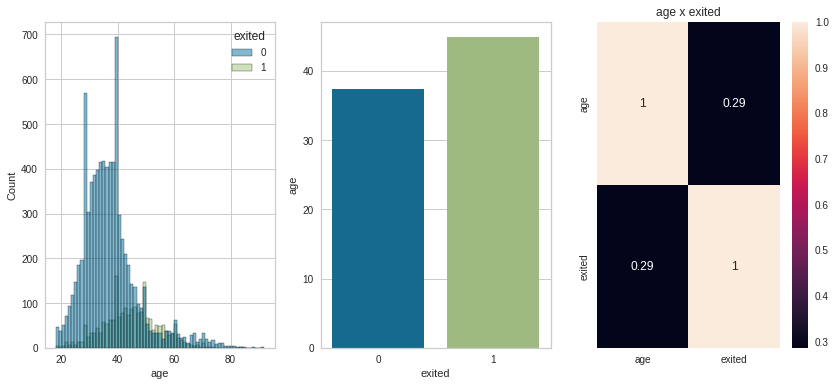

In [20]:
# Building grid
plt.figure(figsize = (14,6));

# Auxiliar dataframe
df_aux = df3[['age','exited']].groupby('exited').mean().reset_index()

# Building graphics
plt.subplot(1,3,1)
sns.histplot(data = df3, x = 'age', hue = 'exited');

plt.subplot(1,3,2)
sns.barplot(data = df_aux, x = 'exited', y = 'age');

plt.subplot(1,3,3)
corr_two(df3[['age']], df3[['exited']]);

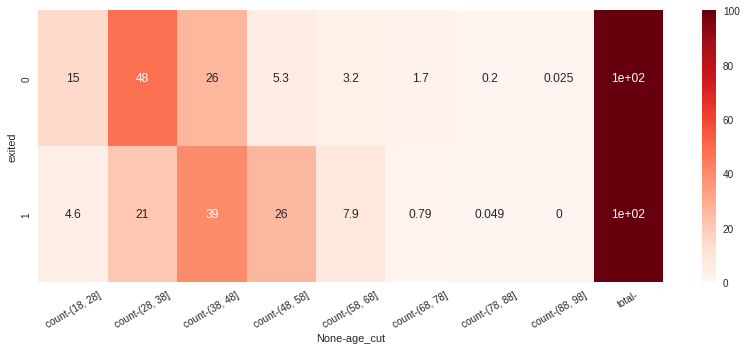

In [21]:
df_aux = df3.copy()

# Create a cut in the data
bins = np.arange(18,100,10)
df_aux['age_cut'] = pd.cut(df_aux['age'], bins = bins)

# Creating Pivot Tables
a = df_aux.pivot_table(values = 'gender', index = 'exited', columns = 'age_cut', aggfunc =['count'])

# Create the variable total
a['total'] = a.sum(axis = 1)

# Calculate a percentage
for col in a.columns:
    a[col] = a[col] / a['total'] *100

# Plot figure
plt.figure(figsize = (14,5));
plt.xticks(rotation = 30);
sns.heatmap(data = a, annot = True, cmap = 'Reds');

### __H2:__ Clients who left have less income?
**FALSE:** churned clients has the same mean income that the clients who stay, and there a little correlation between salary and exited, and the income has a continuous distribution.

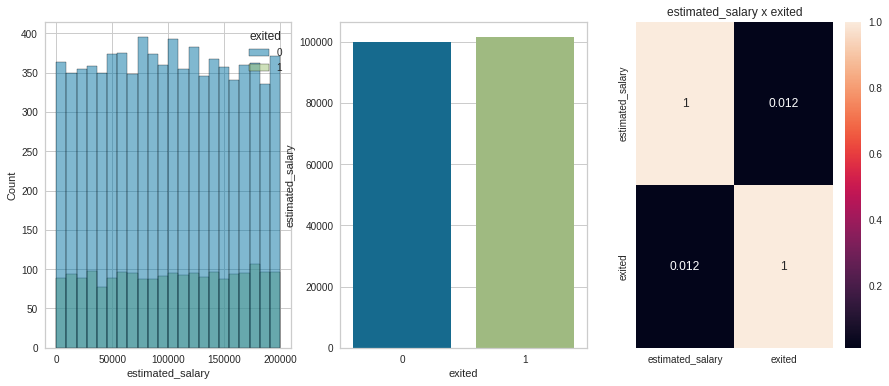

In [22]:
# Building grid
plt.figure(figsize = (15,6))

# Auxiliar dataframe
df_aux = df3[['estimated_salary', 'exited']].groupby('exited').mean().reset_index()

# Building graphics
plt.subplot(1,3,1)
sns.histplot(data = df3, x = 'estimated_salary', hue = 'exited');

plt.subplot(1,3,2)
sns.barplot(data = df_aux, x = 'exited', y = 'estimated_salary');

plt.subplot(1,3,3)
corr_two(df3[['estimated_salary']], df3[['exited']]);

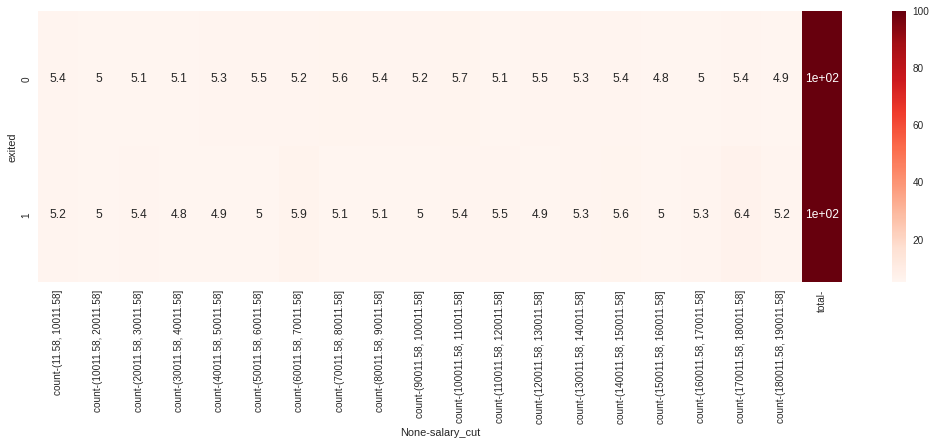

In [23]:
df_aux = df3.copy()

# Create min max
max_salary = df_aux['estimated_salary'].max()
min_salary = df_aux['estimated_salary'].min()

# Create a cut in the data
bins = np.arange(min_salary,max_salary,10000)
df_aux['salary_cut'] = pd.cut(df_aux['estimated_salary'], bins = bins)

# Creating Pivot Tables
a = df_aux.pivot_table(values = 'gender', index = 'exited', columns = 'salary_cut', aggfunc =['count'])

# Create the variable total
a['total'] = a.sum(axis = 1)

# Calculate a percentage
for col in a.columns:
    a[col] = a[col] / a['total'] *100

# Plot figure
plt.figure(figsize = (18,5));
plt.xticks(rotation = 30);
sns.heatmap(data = a, annot = True, cmap = 'Reds');

### __H3:__ Clients who left has a low credit card score?
**FALSE:** churned clients has the same credit card score that the clients who stay, and there is a small correlation between the credit score and churned clients.

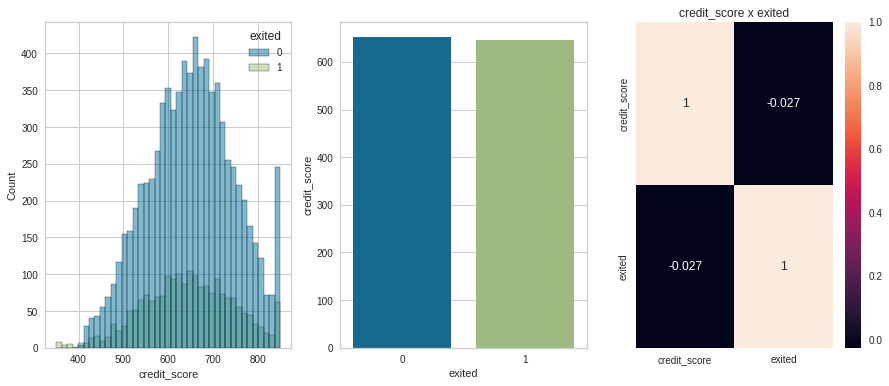

In [24]:
# Building grid
plt.figure(figsize = (15,6))

# Auxiliar dataframe
df_aux = df3[['exited', 'credit_score']].groupby('exited').mean().reset_index()

# Building graphics
plt.subplot(1,3,1)
sns.histplot(data = df3, x = 'credit_score', hue = 'exited');

plt.subplot(1,3,2)
sns.barplot(data = df_aux, x = 'exited', y = 'credit_score');

plt.subplot(1,3,3)
corr_two(df3[['credit_score']], df3[['exited']]);

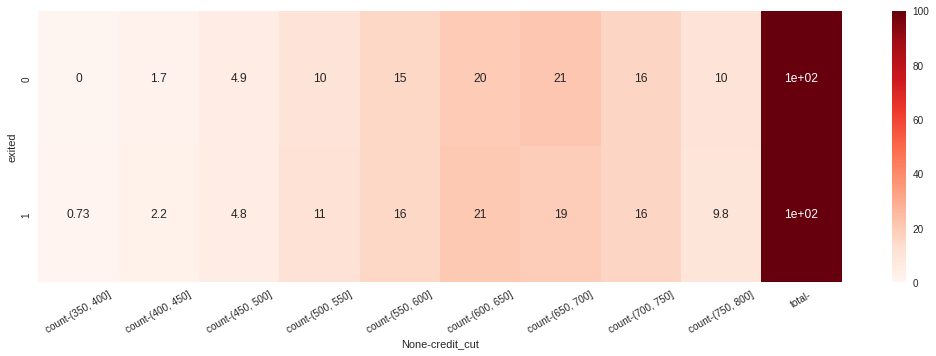

In [25]:
df_aux = df3.copy()

# Create min max
max_credit = df_aux['credit_score'].max()
min_credit = df_aux['credit_score'].min()

# Create a cut in the data
bins = np.arange(min_credit,max_credit,50)
df_aux['credit_cut'] = pd.cut(df_aux['credit_score'], bins = bins)

# Creating Pivot Tables
a = df_aux.pivot_table(values = 'gender', index = 'exited', columns = 'credit_cut', aggfunc =['count'])

# Create the variable total
a['total'] = a.sum(axis = 1)

# Calculate a percentage
for col in a.columns:
    a[col] = a[col] / a['total'] *100

# Plot figure
plt.figure(figsize = (18,5));
plt.xticks(rotation = 30);
sns.heatmap(data = a, annot = True, cmap = 'Reds');

### __H4:__ Clients who left are not active?
**TRUE:** The mean majority of clients who left are not active.

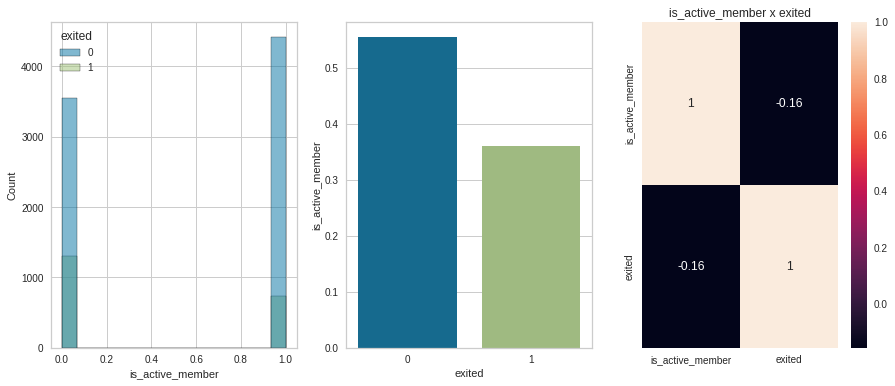

In [26]:
# Building grid
plt.figure(figsize = (15,6))

# Auxiliar dataframe
df_aux = df3[['is_active_member', 'exited']].groupby('exited').mean().reset_index()

#Building graphics
plt.subplot(1,3,1)
sns.histplot(data = df3, x = 'is_active_member', hue = 'exited');

plt.subplot(1,3,2)
sns.barplot(data = df_aux, x = 'exited', y = 'is_active_member');

plt.subplot(1,3,3)
corr_two(df3[['is_active_member']], df3[['exited']]);

### __H5:__ Clients who left buy less products?
**TRUE:** The majority of clients who left buy one product. We see that 60% of the churned clients buy one and two product and 40% buy three and four.

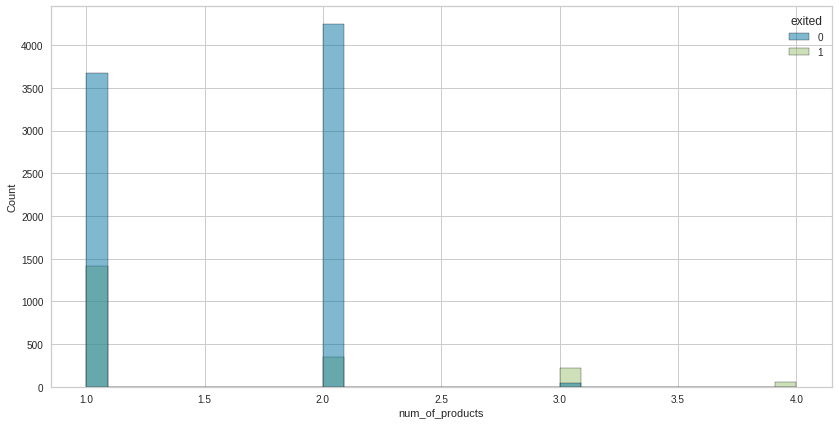

In [27]:
#Building graphics
plt.figure(figsize = (14,7));
sns.histplot(data = df3, x = 'num_of_products', hue = 'exited');

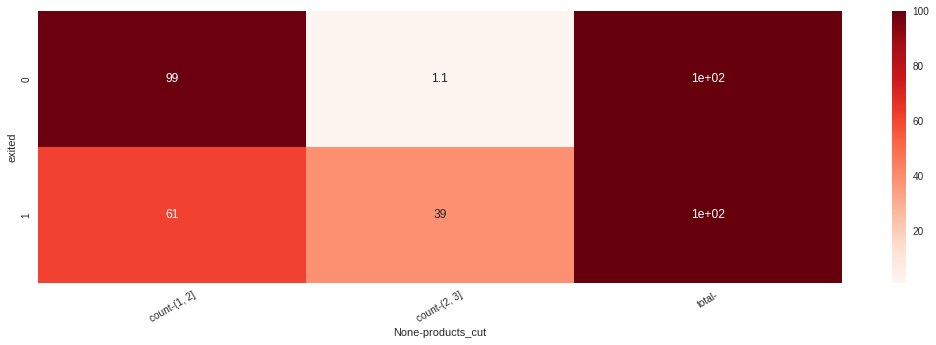

In [28]:
df_aux = df3.copy()

# Create min max
max_credit = df_aux['num_of_products'].max()
min_credit = df_aux['num_of_products'].min()

# Create a cut in the data
bins = np.arange(min_credit,max_credit,1)
df_aux['products_cut'] = pd.cut(df_aux['num_of_products'], bins = bins)

# Creating Pivot Tables
a = df_aux.pivot_table(values = 'gender', index = 'exited', columns = 'products_cut', aggfunc =['count'])

# Create the variable total
a['total'] = a.sum(axis = 1)

# Calculate a percentage
for col in a.columns:
    a[col] = a[col] / a['total'] *100

# Plot figure
plt.figure(figsize = (18,5));
plt.xticks(rotation = 30);
sns.heatmap(data = a, annot = True, cmap = 'Reds');

### __H6:__ Clients who left has a low tenure?
**FALSE:** There is no relation between clients who left and low tenure, it remains constant over the years.

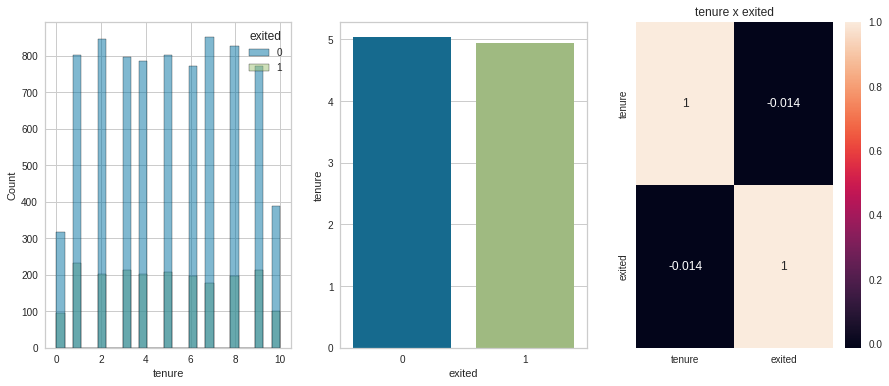

In [29]:
# Building grid
plt.figure(figsize = (15,6));

# Auxiliar dataframe
df_aux = df3[['tenure', 'exited']].groupby('exited').mean().reset_index()

#Building graphics
plt.subplot(1,3,1)
sns.histplot(data = df3, x = 'tenure', hue = 'exited');

plt.subplot(1,3,2)
sns.barplot(data = df_aux, x = 'exited', y = 'tenure');

plt.subplot(1,3,3)
corr_two(df3[['tenure']], df3[['exited']]);

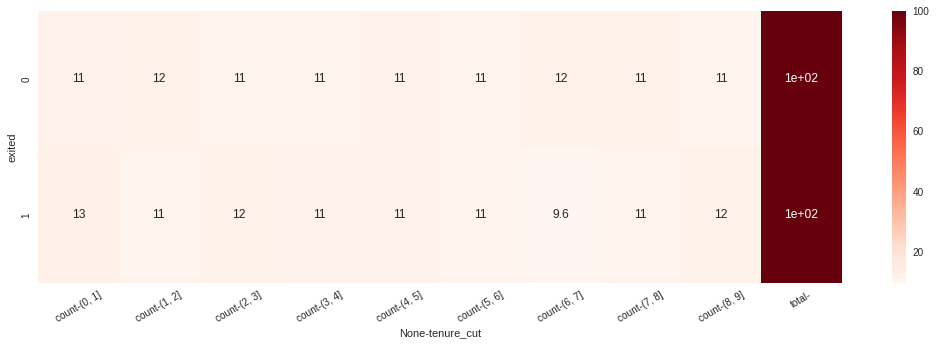

In [30]:
df_aux = df3.copy()

# Create min max
max_credit = df_aux['tenure'].max()
min_credit = df_aux['tenure'].min()

# Create a cut in the data
bins = np.arange(min_credit,max_credit,1)
df_aux['tenure_cut'] = pd.cut(df_aux['tenure'], bins = bins)

# Creating Pivot Tables
a = df_aux.pivot_table(values = 'gender', index = 'exited', columns = 'tenure_cut', aggfunc =['count'])

# Create the variable total
a['total'] = a.sum(axis = 1)

# Calculate a percentage
for col in a.columns:
    a[col] = a[col] / a['total'] *100

# Plot figure
plt.figure(figsize = (18,5));
plt.xticks(rotation = 30);
sns.heatmap(data = a, annot = True, cmap = 'Reds');

### __H7:__ Clients who left has low income?
**FALSE:** There is no relation between clients who left and low income.

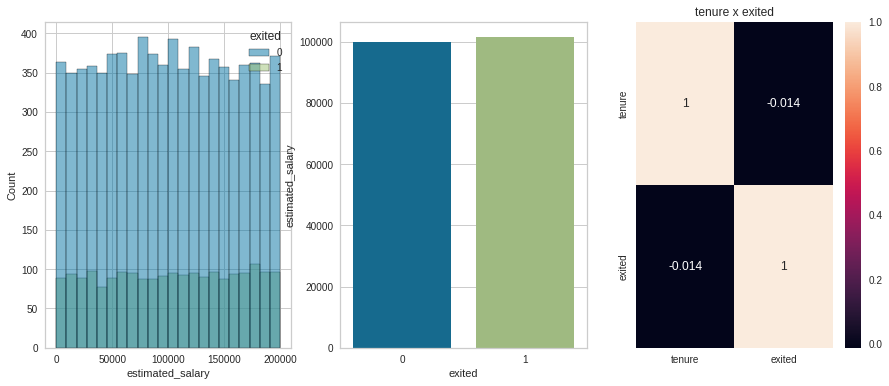

In [31]:
# Building grid
plt.figure(figsize = (15,6));

# Auxiliar dataframe
df_aux = df3[['estimated_salary', 'exited']].groupby('exited').mean().reset_index()

#Building graphics
plt.subplot(1,3,1)
sns.histplot(data = df3, x = 'estimated_salary', hue = 'exited');

plt.subplot(1,3,2)
sns.barplot(data = df_aux, x = 'exited', y = 'estimated_salary');

plt.subplot(1,3,3)
corr_two(df3[['tenure']], df3[['exited']]);

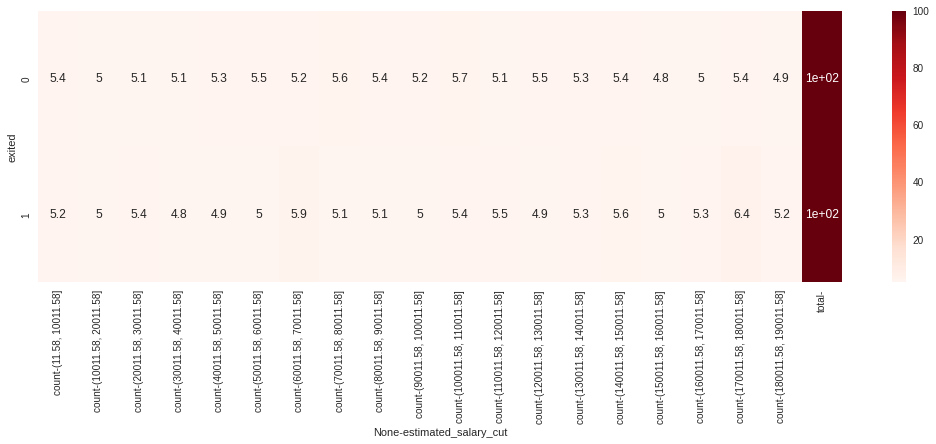

In [32]:
df_aux = df3.copy()

# Create min max
max_credit = df_aux['estimated_salary'].max()
min_credit = df_aux['estimated_salary'].min()

# Create a cut in the data
bins = np.arange(min_credit,max_credit,10000)
df_aux['estimated_salary_cut'] = pd.cut(df_aux['estimated_salary'], bins = bins)

# Creating Pivot Tables
a = df_aux.pivot_table(values = 'gender', index = 'exited', columns = 'estimated_salary_cut', aggfunc =['count'])

# Create the variable total
a['total'] = a.sum(axis = 1)

# Calculate a percentage
for col in a.columns:
    a[col] = a[col] / a['total'] *100

# Plot figure
plt.figure(figsize = (18,5));
plt.xticks(rotation = 30);
sns.heatmap(data = a, annot = True, cmap = 'Reds');

### __H8:__ Clients who left has low balance?
**FALSE:** There is no relation between clients who left and low balance, the clients who left have more balance than who stay.

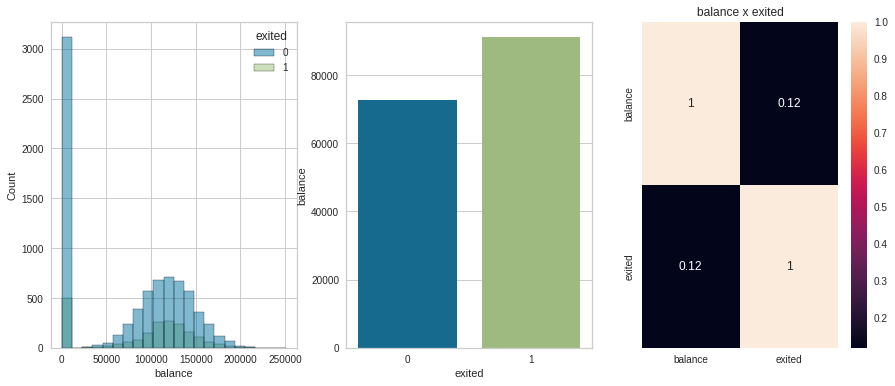

In [33]:
# Building grid
plt.figure(figsize = (15,6));

# Auxiliar dataframe
df_aux = df3[['balance', 'exited']].groupby('exited').mean().reset_index()

#Building graphics
plt.subplot(1,3,1)
sns.histplot(data = df3, x = 'balance', hue = 'exited');

plt.subplot(1,3,2)
sns.barplot(data = df_aux, x = 'exited', y = 'balance');

plt.subplot(1,3,3)
corr_two(df3[['balance']], df3[['exited']]);

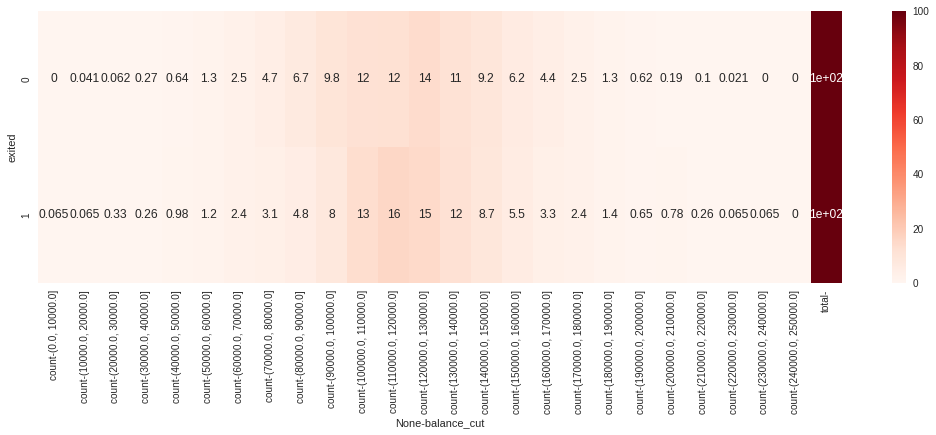

In [34]:
df_aux = df3.copy()

# Create min max
max_credit = df_aux['balance'].max()
min_credit = df_aux['balance'].min()

# Create a cut in the data
bins = np.arange(min_credit,max_credit,10000)
df_aux['balance_cut'] = pd.cut(df_aux['balance'], bins = bins)

# Creating Pivot Tables
a = df_aux.pivot_table(values = 'gender', index = 'exited', columns = 'balance_cut', aggfunc =['count'])

# Create the variable total
a['total'] = a.sum(axis = 1)

# Calculate a percentage
for col in a.columns:
    a[col] = a[col] / a['total'] *100

# Plot figure
plt.figure(figsize = (18,5));
plt.xticks(rotation = 30);
sns.heatmap(data = a, annot = True, cmap = 'Reds');

### H9: The churned clients has hight amount 
**FALSE:** There is a small correlation between amount and exited.

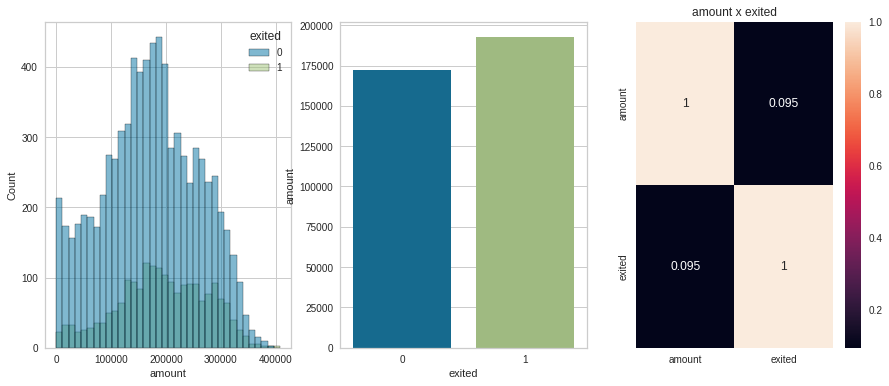

In [35]:
# Building grid
plt.figure(figsize = (15,6));

# Auxiliar dataframe
df_aux = df3[['amount', 'exited']].groupby('exited').mean().reset_index()

#Building graphics
plt.subplot(1,3,1)
sns.histplot(data = df3, x = 'amount', hue = 'exited');

plt.subplot(1,3,2)
sns.barplot(data = df_aux, x = 'exited', y = 'amount');

plt.subplot(1,3,3)
corr_two(df3[['amount']], df3[['exited']]);

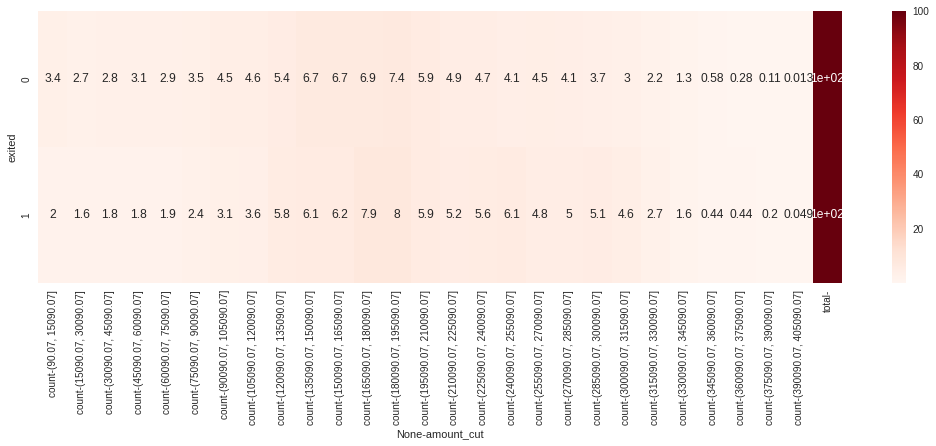

In [36]:
df_aux = df3.copy()

# Create min max
max_credit = df_aux['amount'].max()
min_credit = df_aux['amount'].min()

# Create a cut in the data
bins = np.arange(min_credit,max_credit,15000)
df_aux['amount_cut'] = pd.cut(df_aux['amount'], bins = bins)

# Creating Pivot Tables
a = df_aux.pivot_table(values = 'gender', index = 'exited', columns = 'amount_cut', aggfunc =['count'])

# Create the variable total
a['total'] = a.sum(axis = 1)

# Calculate a percentage
for col in a.columns:
    a[col] = a[col] / a['total'] *100

# Plot figure
plt.figure(figsize = (18,5));
plt.xticks(rotation = 30);
sns.heatmap(data = a, annot = True, cmap = 'Reds');

### Hipothesis Resume

In [37]:
resume = {'hipothesis' :   ['H1',      'H2',   'H3',    'H4',    'H5',   'H6',   'H7',    'H8',     'H9'],
         'classification': ['False', 'False', 'False', 'True', 'True', 'False', 'False', 'False', 'False'],
         'relevance':      ['Medium','Medium','Medium','Small','Small','Small', 'Median','Median','Median']}
df_resume = pd.DataFrame(resume).set_index('hipothesis').T
df_resume

hipothesis,H1,H2,H3,H4,H5,H6,H7,H8,H9
classification,False,False,False,True,True,False,False,False,False
relevance,Medium,Medium,Medium,Small,Small,Small,Median,Median,Median


## Multivariated Analysis
In this section we'll make an analysis using more than two variables.

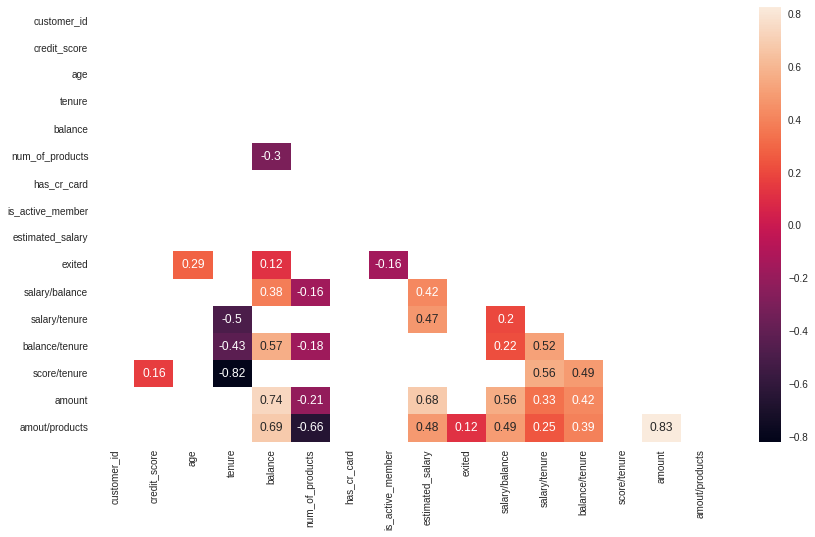

In [38]:
# Figure size
plt.figure(figsize = (14,8));

# Correlation above 10%
corr = df3.corr()
mask = np.triu(np.ones_like(corr, dtype=bool));
sns.heatmap(corr[(corr > .1) | (corr < -.1)], annot = True, mask = mask);

- We can see that the age and balance has more correlation with the exited.
- The highest correlation like salary/tenure and score/tenure is because the variance of the same variable. So we have to take this in mind when we'll transform the data.
___

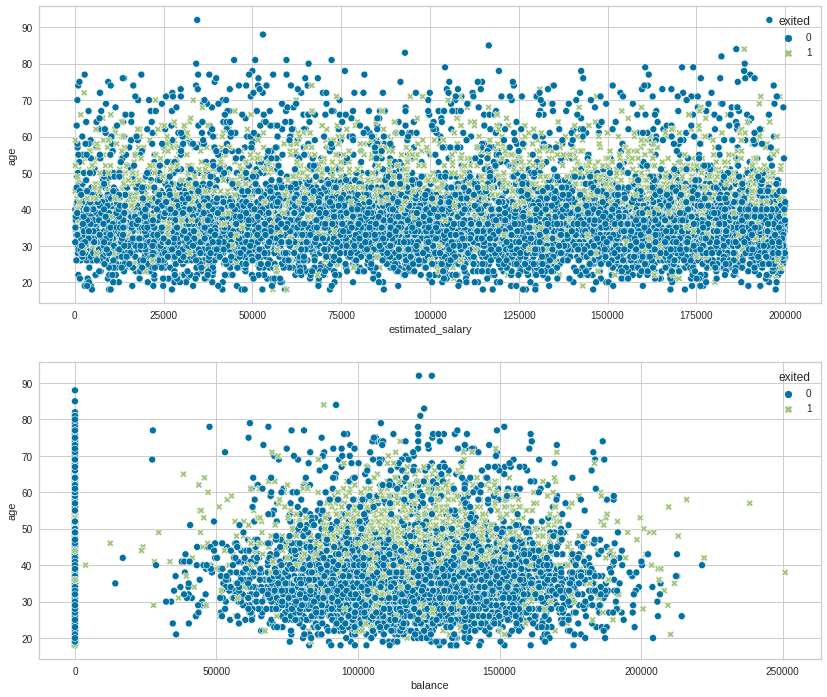

In [39]:
fig, axis = plt.subplots(2,1, figsize = (14,12));
sns.scatterplot(data = df3, x = 'estimated_salary', y = 'age', hue = 'exited', style='exited', cmap = 'GnBu', ax = axis[0]);
sns.scatterplot(data = df3, x = 'balance', y = 'age', hue = 'exited', style='exited', cmap = 'GnBu', ax = axis[1]);

We see that the majority of people who left are between the age 50 and 60.
___

<AxesSubplot:xlabel='geography', ylabel='balance'>

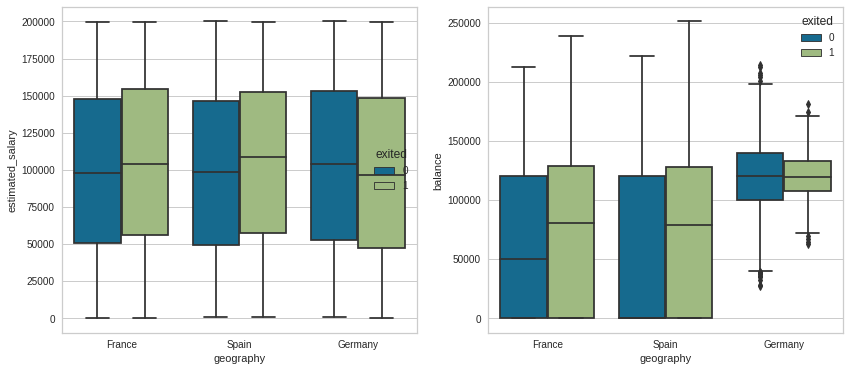

In [40]:
fig, axis  = plt.subplots(1,2, figsize = (14,6));
sns.boxplot(data = df3, x = 'geography', y = 'estimated_salary', hue = 'exited', ax = axis[0])
sns.boxplot(data = df3, x = 'geography', y = 'balance', hue = 'exited', ax = axis[1])

We see that germany has the highest balance comparing to France and Spain. 
___

# DATA PREPARATION

In this section we'll make some preparations in our data make it more "readable" for machine learning algorithms, following the next steps:

- **Verification:** Verify if our variables has outliers and have normal distribution.
- **Rescaling:** We'll rescale the numerical data into a range between -1 and 1, and change the categorical data into 0 and 1.
- **Balancing Data:** This section we'll balance the target data in order to avoid accuracy problem.

In [41]:
df4 = df3.copy()

In [42]:
df4.drop(['amount', 'amout/products', 'customer_id'], axis = 1, inplace = True)

## Verification

we'll check if in our variables has a large or small numbers of outliers and we verify if there is some columns that behave like a normal curve.

### Normal Verification

In this section we'll verify that is a variable that behave like a normal curve.

In [43]:
df4_num = df4.select_dtypes(include = ['int64', 'float64'])
list_aux= ['credit_score', 'age', 'balance', 'estimated_salary', 'salary/balance', 'balance/tenure', 'score/tenure']

for col in list_aux:
    stat, p = normaltest(df4_num[col])
    print('stat: %.3f, p: %.3f' %(stat, p))
    if p > 0.05:
        print('{}: Probably Gaussian\n'.format(col))
    else:
        print('{}: Probably Not Gaussian\n'.format(col))

stat: 132.828, p: 0.000
credit_score: Probably Not Gaussian

stat: 1507.791, p: 0.000
age: Probably Not Gaussian

stat: 62973.390, p: 0.000
balance: Probably Not Gaussian

stat: 7397.150, p: 0.000
estimated_salary: Probably Not Gaussian

stat: 21858.410, p: 0.000
salary/balance: Probably Not Gaussian

stat: 4684.613, p: 0.000
balance/tenure: Probably Not Gaussian

stat: 2571.618, p: 0.000
score/tenure: Probably Not Gaussian



In [44]:
df4_num = df4.select_dtypes(include = ['int64', 'float64'])
list_aux= ['credit_score', 'age', 'balance', 'estimated_salary', 'salary/balance', 'balance/tenure', 'score/tenure']

for col in list_aux:
    stat, p = jarque_bera(df4_num[col])
    print('stat: %.3f, p: %.3f' %(stat, p))
    if p > 0.05:
        print('{}: Probably Gaussian\n'.format(col))
    else:
        print('{}: Probably Not Gaussian\n'.format(col))

stat: 84.198, p: 0.000
credit_score: Probably Not Gaussian

stat: 2513.842, p: 0.000
age: Probably Not Gaussian

stat: 957.308, p: 0.000
balance: Probably Not Gaussian

stat: 581.677, p: 0.000
estimated_salary: Probably Not Gaussian

stat: 441238642.672, p: 0.000
salary/balance: Probably Not Gaussian

stat: 22574.005, p: 0.000
balance/tenure: Probably Not Gaussian

stat: 5099.513, p: 0.000
score/tenure: Probably Not Gaussian



### Outlier Verification

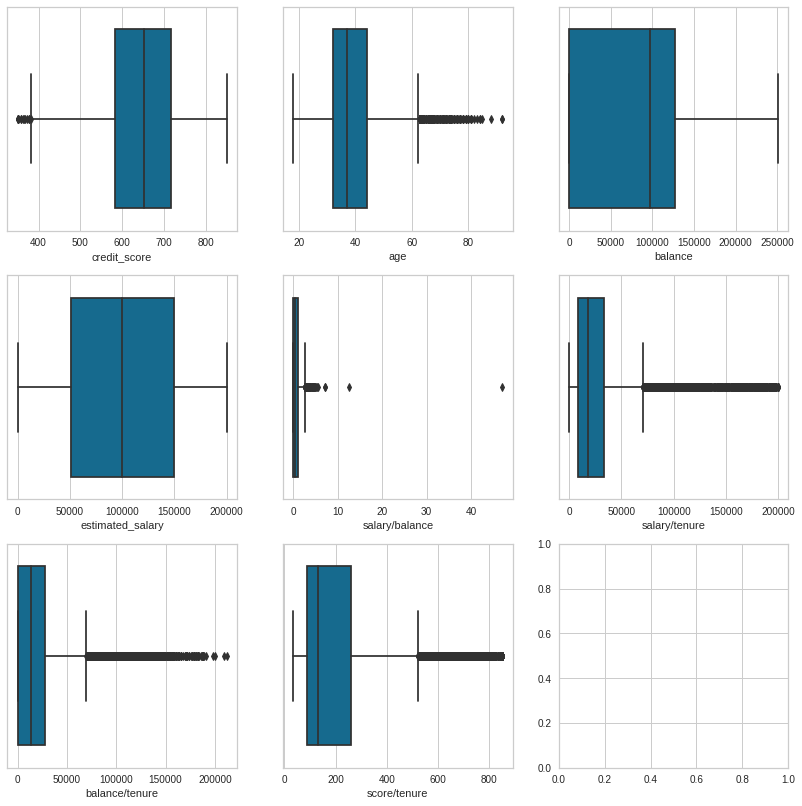

In [45]:
df4_num = df4.select_dtypes(include = ['int64', 'float64'])

fig, axis = plt.subplots(3,3, figsize = (14,14))

sns.boxplot(data = df4_num, x = 'credit_score', ax = axis[0,0]);
sns.boxplot(data = df4_num, x = 'age', ax = axis[0,1]);
sns.boxplot(data = df4_num, x = 'balance', ax = axis[0,2]);

sns.boxplot(data = df4_num, x = 'estimated_salary', ax = axis[1,0]);
sns.boxplot(data = df4_num, x = 'salary/balance', ax = axis[1,1]);
sns.boxplot(data = df4_num, x = 'salary/tenure', ax = axis[1,2]);

sns.boxplot(data = df4_num, x = 'balance/tenure', ax = axis[2,0]);
sns.boxplot(data = df4_num, x = 'score/tenure', ax = axis[2,1]);

We see that the variables what has a **big outliers** are the **age**, **salary/balance**, **balance/tenure** and **score/tenure**.

## Rescaling

This section we'll rescale the numerical data and transform the categorical data.

### Transforming

In this section we'll transform the numerical data into numbers that has a range between -1 and 1, so we'll use the algorithms below: <br>
- **MinMaxScaler:** Is used when we have small number of outliers.
- **RobustScaler:** Is used when we have a large number of outliers.

In [46]:
mms = MinMaxScaler()
rs = RobustScaler()

In [47]:
# MinMaxScaler 
df4['credit_score'] = mms.fit_transform(df4[['credit_score']].values)
df4['balance'] = mms.fit_transform(df4[['balance']].values)
df4['estimated_salary'] = mms.fit_transform(df4[['estimated_salary']].values)

# RobustScaler
df4['age'] = rs.fit_transform(df4[['age']].values)
df4['salary/balance'] = rs.fit_transform(df4[['salary/balance']].values)
df4['salary/tenure'] = rs.fit_transform(df4[['salary/tenure']].values)
df4['balance/tenure'] = rs.fit_transform(df4[['balance/tenure']].values)
df4['score/tenure'] = rs.fit_transform(df4[['score/tenure']].values)

### Encoding

This section we'll transform the categorical data into numerical one, in this section we'll transform the categorical data in 0 and 1.

In [48]:
df4 = pd.get_dummies(df4, prefix = 'geography', columns = ['geography'])
df4 = pd.get_dummies(df4, prefix = 'gender', columns = ['gender'])

### Data Verification

Next we'll verify if there is any alteration after rescaling our data.

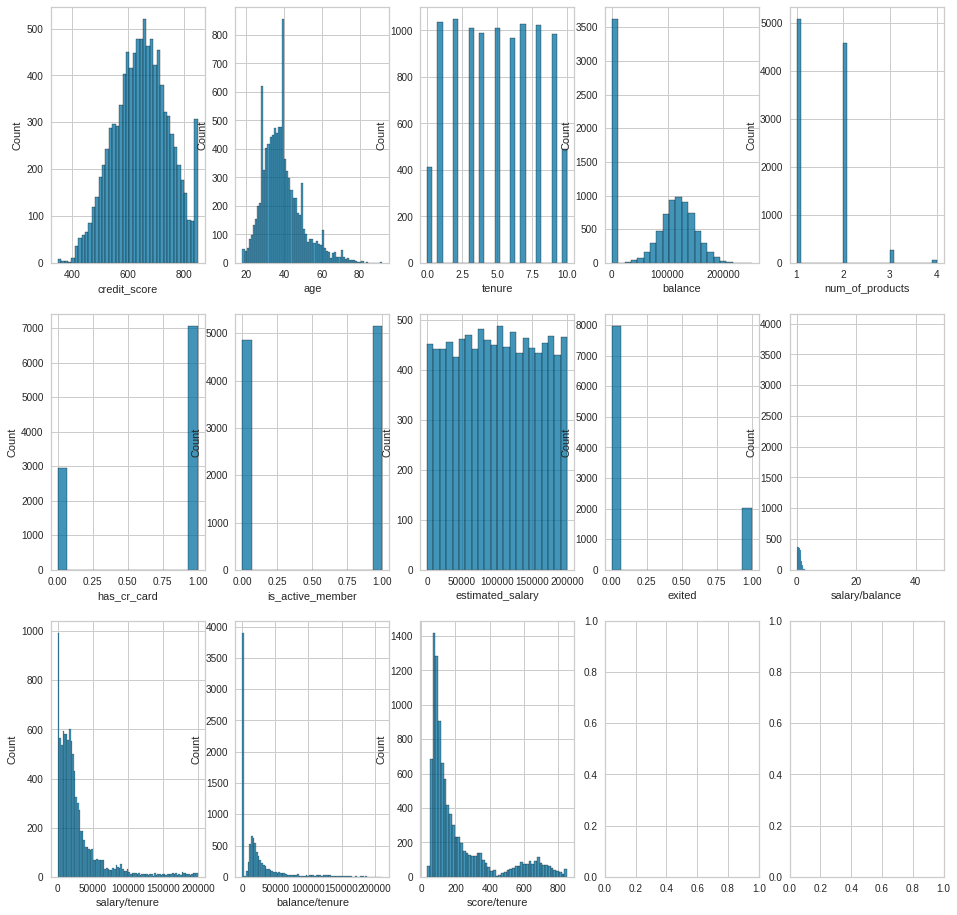

In [49]:
fig, axis = plt.subplots(3,5, figsize = (16,16))

sns.histplot(data = df4_num, x = 'credit_score', ax = axis[0,0]);
sns.histplot(data = df4_num, x = 'age', ax = axis[0,1]);
sns.histplot(data = df4_num, x = 'tenure', ax = axis[0,2]);
sns.histplot(data = df4_num, x = 'balance', ax = axis[0,3]);
sns.histplot(data = df4_num, x = 'num_of_products', ax = axis[0,4]);

sns.histplot(data = df4_num, x = 'has_cr_card', ax = axis[1,0]);
sns.histplot(data = df4_num, x = 'is_active_member', ax = axis[1,1]);
sns.histplot(data = df4_num, x = 'estimated_salary', ax = axis[1,2]);
sns.histplot(data = df4_num, x = 'exited', ax = axis[1,3]);
sns.histplot(data = df4_num, x = 'salary/balance', ax = axis[1,4]);

sns.histplot(data = df4_num, x = 'salary/tenure', ax = axis[2,0]);
sns.histplot(data = df4_num, x = 'balance/tenure', ax = axis[2,1]);
sns.histplot(data = df4_num, x = 'score/tenure', ax = axis[2,2]);

## Balancing Data

One thing that we realize during our data exploration, is the **umbalance** data in our **target variable**, we see that aproximately **80% are not churned** clients and **20% are churned**. <br>
One thing that we gonna do is **balance** the **not majoring data**.  

In [50]:
# Separate the data in X and y
X = df4.drop('exited', axis = 1)
y = df4['exited']

In [51]:
# Separate the imbalance data into train and test
X_train_imb, X_test, y_train_imb, y_test = train_test_split(X, y, train_size = .8, 
                                                                random_state = 42, stratify = y)

In [52]:
# Using the SMOTETomek to majoring data
resample = SMOTETomek(random_state = 42, n_jobs = -1)
X_train, y_train = resample.fit_resample(X_train_imb, y_train_imb)

<AxesSubplot:ylabel='count'>

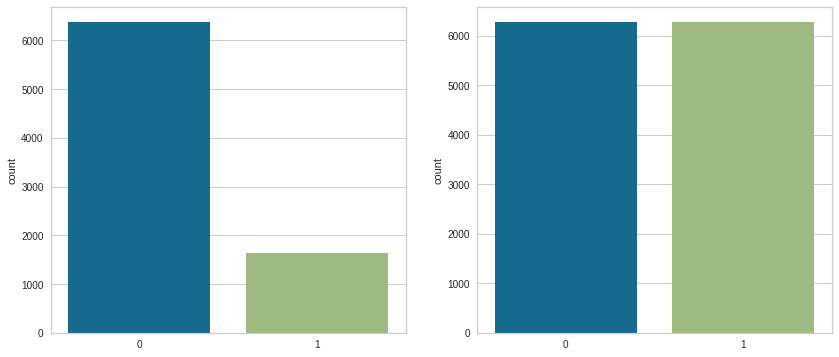

In [53]:
# Verify the imbalance data
fig, axis  = plt.subplots(1,2, figsize = (14,6));
sns.countplot(x= y_train_imb.values, ax = axis[0])
sns.countplot(x= y_train.values, ax = axis[1])

## Feature Selection

In this section we'll **select features** using the **random forest** and **boruta** algorithm in order to compare the output of both and take our decision by choosing one of them. <br>
Because the data is small we can use the boruta algorithm, if the data contain a large number of rows ,1.000.000 for example, it will take too many time depending of the algorithm.

### Random Forest Selector

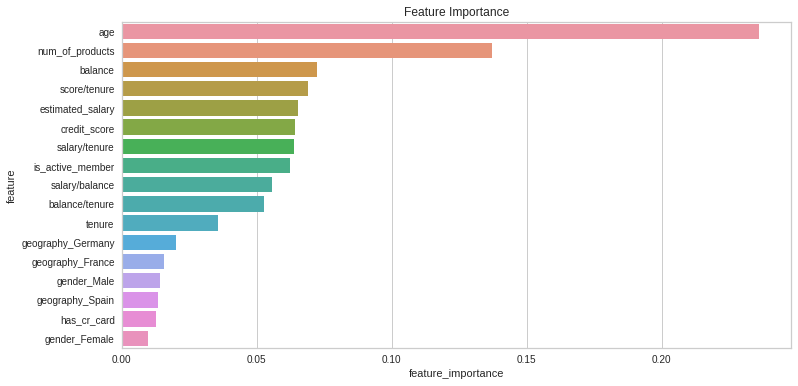

In [54]:
# Build and training using the Random Forest
rf = RandomForestClassifier(random_state = 42, n_estimators = 300, n_jobs = -1)
rf.fit(X_train, y_train)

# Creating a Dataframe
feat_imp = pd.DataFrame({'feature': X_train.columns,
                        'feature_importance': rf.feature_importances_})\
                        .sort_values('feature_importance', ascending=False)\
                        .reset_index(drop=True)


# plot feature importance
plt.subplots(figsize=(12,6))
sns.barplot(x='feature_importance', y='feature', data=feat_imp, orient='h')\
    .set_title('Feature Importance');

### Boruta 

In [55]:
# Training the boruta algorithm
boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 42).fit(X_train.values, y_train.values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	10
Tentative: 	0
Rejected: 	7


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	10
Tentative: 	0
Rejected: 	7


In [56]:
cols_selected = boruta.support_.tolist()

cols_selected_boruta = X_train.iloc[:, cols_selected].columns.tolist()
cols_not_selected_boruta = list(np.setdiff1d(X_train.columns, cols_selected_boruta))

In [57]:
cols_not_selected_boruta

['gender_Female',
 'gender_Male',
 'geography_France',
 'geography_Germany',
 'geography_Spain',
 'has_cr_card',
 'tenure']

In [58]:
cols_selected_boruta

['credit_score',
 'age',
 'balance',
 'num_of_products',
 'is_active_member',
 'estimated_salary',
 'salary/balance',
 'salary/tenure',
 'balance/tenure',
 'score/tenure']

We can see that **both algotithms** give the **same results**, so we can choose both of them, in this case we'll **choose** the **boruta algorithm**. 

# MACHINE LEARNING

In this section we'll use some machine learning algorithms in order to avaliate which has the best performance:

 - **SVM:** This model generate cuts in the space in order to segregate the classes in the best way.
 - **Random Forest:** We used this algorithm before to select variables, and it uses a decision tree base in order to give us a binary result.
 - **Ada Boost:** it's an algorithm that use stumps (small trees) considered weak learners, and gives on  weight in the training data.
 - **XG Boost:** It's an algoritm that use trees but different way than Random forest because they use time learning in order to improve the algorithm, in other words, the new tree is build after they learning the mistakes about the previous one. 
 - **Cat Boost:** It has the same logic of the decision tree, but this algorithm perform better on categorical data.

In [59]:
x_train = X_train[cols_selected_boruta].values
x_test = X_test[cols_selected_boruta].values

## Fit the models
Now we'll fit the models with and without the cross validation method in order to make future comparisons in our algorithm. 

### SVC Model

In [60]:
# SVC Model
svc = SVC(random_state = 42, probability = True)
svc.fit(x_train, y_train)

SVC(probability=True, random_state=42)

### Logistic Regression

In [61]:
# Logistic Regression
lg = LogisticRegression(random_state = 42)
lg.fit(x_train, y_train)

LogisticRegression(random_state=42)

### Random Forest

In [62]:
# Random Forest
rf = RandomForestClassifier(random_state = 42, n_estimators = 500, n_jobs = -1)
rf.fit(x_train, y_train)

RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)

### Ada Boost Classifier

In [63]:
# Ada Boost Classifier
adc = AdaBoostClassifier(n_estimators= 100, random_state = 42)
adc.fit(x_train, y_train)

AdaBoostClassifier(n_estimators=100, random_state=42)

### XG Boost

In [64]:
# XG Boost
xgb = XGBClassifier(n_estimators = 500, random_state = 42, n_jobs = -1, eval_metric = 'logloss', use_label_encoder =False)
xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

### Cat Boost 

In [162]:
# Cat Boost
ct = CatBoostClassifier(iterations = 500, random_seed = 42, eval_metric = 'BalancedAccuracy', verbose = False)
ct_wr = wrap(ct)
ct_wr.fit(x_train, y_train, eval_set = (x_test, y_test), use_best_model = True, plot = False)

## Models Evaluation

### Class Prediction
- In this evaluation we'll see how the algorithms evaluate quantitatively of churned and not churned clients.
- We see in this case that the **Random Forest**, **AdaBoost** and **CatBoost** have the best performance.

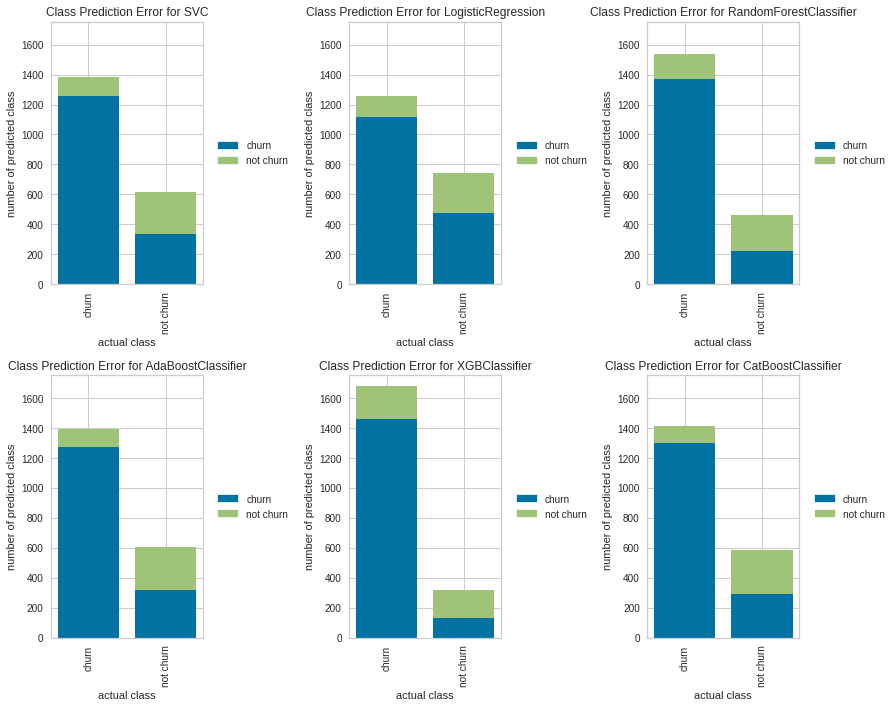

In [163]:
fig, axis = plt.subplots(2,3, figsize = (14,10));

# SVC model
visualizer = ClassPredictionError(svc, classes = ['churn', 'not churn'], ax = axis[0,0])
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
g = visualizer.finalize()

# Logistic Regression
visualizer = ClassPredictionError(lg, classes = ['churn', 'not churn'], ax = axis[0,1])
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
g = visualizer.finalize()

# Random Forest
visualizer = ClassPredictionError(rf, classes = ['churn', 'not churn'], ax = axis[0,2])
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
g = visualizer.finalize()

# Ada Boost Classifier
visualizer = ClassPredictionError(adc, classes = ['churn', 'not churn'], ax = axis[1,0])
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
g = visualizer.finalize()

# XG Boost Classifier
visualizer = ClassPredictionError(xgb, classes = ['churn', 'not churn'], ax = axis[1,1])
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
g = visualizer.finalize()

# Cat Boost Classifier
visualizer = ClassPredictionError(ct_wr, classes = ['churn', 'not churn'], ax = axis[1,2])
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
g = visualizer.finalize()

### Confusion Matrix
- This metric was a complementation with the previous graphic, in this graphic we can quantify better how much churn clients our algorithm predict.
- We can see that **AdaBoost** and **Catboost** have the best perfomance.

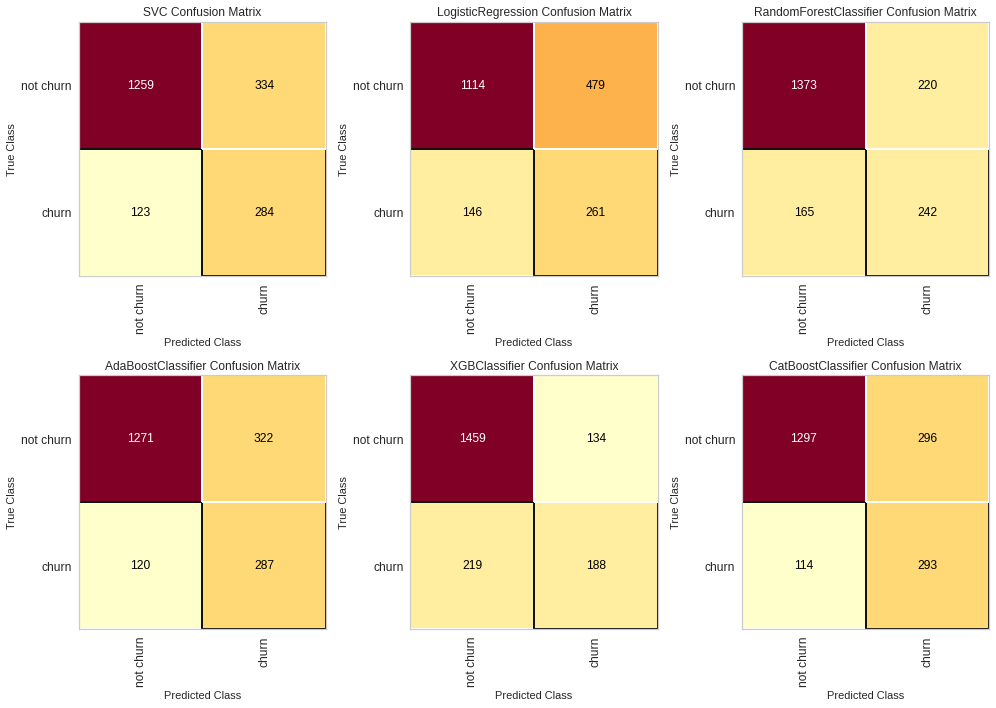

In [67]:
fig, axis = plt.subplots(2,3, figsize = (14,10));

# SVC model
visualizer = ConfusionMatrix(svc, classes = ['not churn', 'churn'], ax = axis[0,0])
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
g = visualizer.finalize()

# Logistic Regression
visualizer = ConfusionMatrix(lg, classes = ['not churn', 'churn'], ax = axis[0,1])
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
g = visualizer.finalize()

# Random Forest
visualizer = ConfusionMatrix(rf, classes = ['not churn', 'churn'], ax = axis[0,2])
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
g = visualizer.finalize()

# Ada Boost Classifier
visualizer = ConfusionMatrix(adc, classes = ['not churn', 'churn'], ax = axis[1,0])
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
g = visualizer.finalize()

# XG Boost Classifier
visualizer = ConfusionMatrix(xgb, classes = ['not churn', 'churn'], ax = axis[1,1])
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
g = visualizer.finalize()

# Cat Boost Classifier
visualizer = ConfusionMatrix(ct_wr, classes = ['not churn', 'churn'], ax = axis[1,2])
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
g = visualizer.finalize()

### Classification Metrics
- This sector we'll use the metric **Recall**, **precision** and **f1 score**.
- We can see that **Ada Boost** and **Cat Boost** has the same scores in the churned clients and have the higher scores comparing with other algorithms.

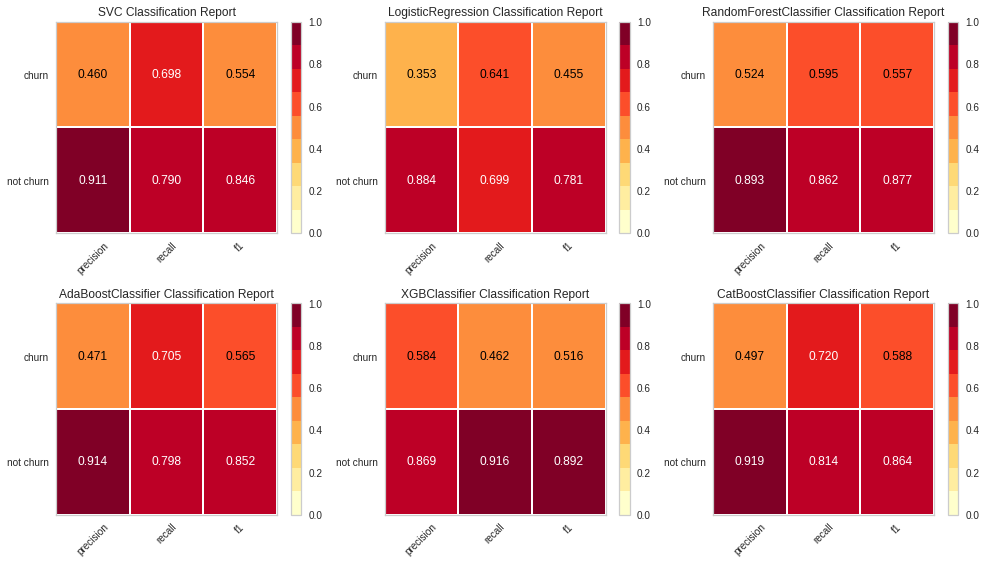

In [68]:
fig, axis = plt.subplots(2,3, figsize = (14,8));

# SVC model
visualizer = ClassificationReport(svc, classes = ['not churn', 'churn'], ax = axis[0,0])
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
g = visualizer.finalize()

# Logistic Regression
visualizer = ClassificationReport(lg, classes = ['not churn', 'churn'], ax = axis[0,1])
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
g = visualizer.finalize()

# Random Forest
visualizer = ClassificationReport(rf, classes = ['not churn', 'churn'], ax = axis[0,2])
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
g = visualizer.finalize()

# Ada Boost Classifier
visualizer = ClassificationReport(adc, classes = ['not churn', 'churn'], ax = axis[1,0])
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
g = visualizer.finalize()

# XG Boost Classifier
visualizer = ClassificationReport(xgb, classes = ['not churn', 'churn'], ax = axis[1,1])
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
g = visualizer.finalize()

# Cat Boost Classifier
visualizer = ClassificationReport(ct_wr, classes = ['not churn', 'churn'], ax = axis[1,2])
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
g = visualizer.finalize()

### ROC AUC Curve
- The ROC curve measure the performance of our model with the churned clients.
- In this metric, only the Logistic Regression has the worst AUC (Area Under the Curve), the other algorithms have better results, so using this metric we can't classify which is the best algorithm.

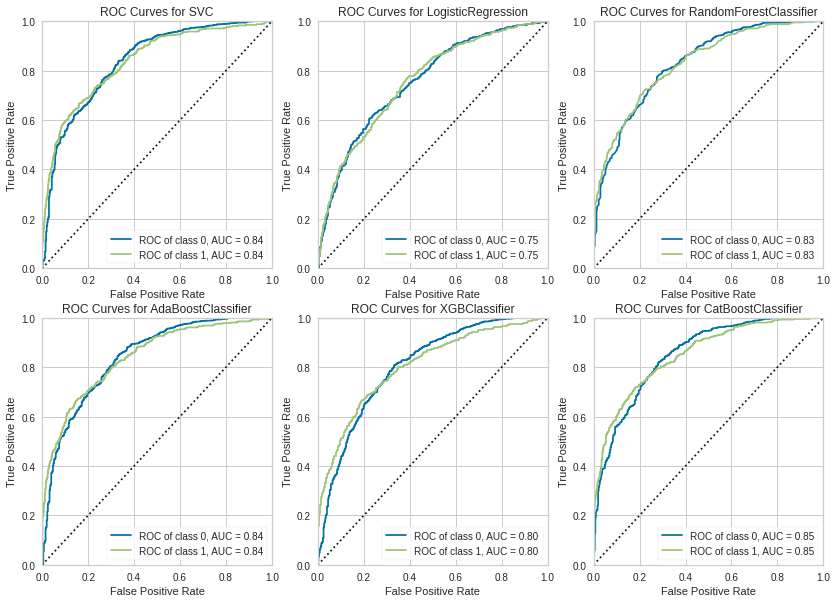

In [69]:
fig, axis = plt.subplots(2,3, figsize = (14,10));

# SVC 
viz = ROCAUC(svc, iso_f1_curves = True, micro = False, macro = False, ax = axis[0,0])
viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.finalize()

# Logistic Regression
viz = ROCAUC(lg, iso_f1_curves = True, micro = False, macro = False, ax = axis[0,1])
viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.finalize()

# Random Forest
viz = ROCAUC(rf, iso_f1_curves = True, micro = False, macro = False, ax = axis[0,2])
viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.finalize()

# Ada Boost Classifier
viz = ROCAUC(adc, iso_f1_curves = True, micro = False, macro = False, ax = axis[1,0])
viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.finalize()

# XG Boost Classifier
viz = ROCAUC(xgb, iso_f1_curves = True, micro = False, macro = False, ax = axis[1,1])
viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.finalize()

# Cat Boost Classifier
viz = ROCAUC(ct_wr, iso_f1_curves = True, micro = False, macro = False, ax = axis[1,2])
viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.finalize()

### KS Statistic
In this graphic we'll see the **cumulative difference** between **True Positive** and **True Negative** rate, this model **measure how much** the **algorithm** can **discriminate between positive** and **negative labels**.
- We can see the algorithm whitch has the **best performance** in this metric is the **SVC** and **Cat Boost**.

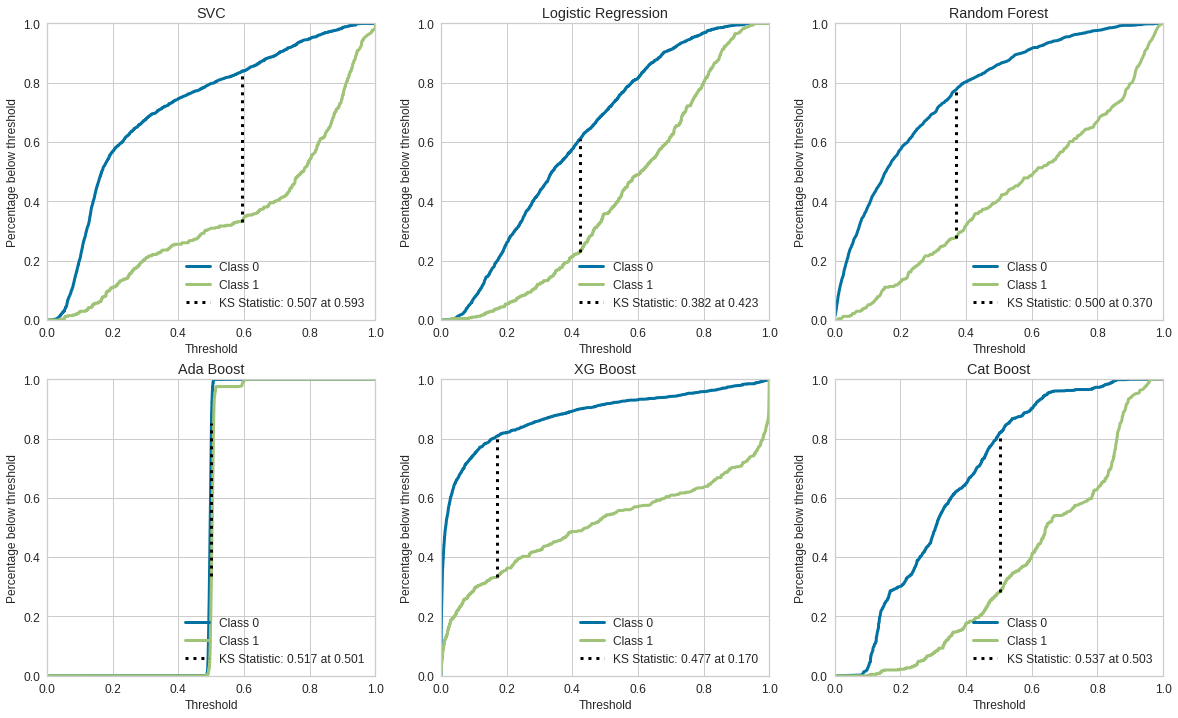

In [70]:
fig, axis = plt.subplots(2,3, figsize=(20,12));

# SVC 
svc_pred = svc.predict_proba(x_test)
plot_ks_statistic(y_test, svc_pred, ax = axis[0,0], title = 'SVC')

# Logistic Regression 
lg_pred = lg.predict_proba(x_test)
plot_ks_statistic(y_test, lg_pred, ax = axis[0,1], title = 'Logistic Regression')

# Random Forest 
rf_pred = rf.predict_proba(x_test)
plot_ks_statistic(y_test, rf_pred, ax = axis[0,2], title = 'Random Forest')

# Ada Boost Classifier 
adc_pred = adc.predict_proba(x_test)
plot_ks_statistic(y_test, adc_pred, ax = axis[1,0], title = 'Ada Boost')

# XG Boost Classifier 
xgb_pred = xgb.predict_proba(x_test)
plot_ks_statistic(y_test, xgb_pred, ax = axis[1,1], title = 'XG Boost')

# Cat Boost Classifier 
ct_wr_pred = ct_wr.predict_proba(x_test)
plot_ks_statistic(y_test, ct_wr_pred, ax = axis[1,2], title = 'Cat Boost');

## Conclusion
After all this analysis we conclude the **Cat Boost** has the best performance using the evaluation metrics below. After that we'll use this model to 

# HIPERPARAMETER FINE TUNNING

In [136]:
ct.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'BalancedAccuracy',
 'iterations': 500,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': True,
 'class_names': [0, 1],
 'random_seed': 42,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'Logloss',
 'learning_rate': 0.08001799881458282,
 '

In [190]:
 parameters =    {  'learning_rate': stats.uniform(0.01, 0.1),
                   'iterations': stats.randint(500, 1000),
                   'depth': stats.randint(6,10),
                   'l2_leaf_reg':stats.randint(1, 5),
                   'border_count': [254],
                   'eval_metric': ['F1'],
                   'verbose':[False]
                }

model = CatBoostClassifier()

randomized_search = RandomizedSearchCV( estimator = model,
                                        param_distributions = parameters, 
                                        scoring = 'f1', n_iter = 50,
                                        cv = 10, n_jobs = -1, refit = True, 
                                        random_state = 42)

randomized_search.fit(X_train, y_train)

KeyboardInterrupt: 